In [131]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import os
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d

In [ ]:
def resample(s: pd.Series) -> pd.Series:
    """
    Resample a pandas Series with unevenly spaced time indices to be even.

    Parameters
    ----------
    s : pd.Series
        The input signal as a pandas Series. The Series index should be time.

    Returns
    -------
    tuple
        The resampled signal as a pandas Series, resampling period as a float,
        and new timebase as a numpy array.
    """
    assert isinstance(s, pd.Series)
    
    # Resampling parameters - change these to suit your data
    resampling_period = s.index.to_series().diff().mean()
    
    # Interpolate to a new time base (resample)
    f_interp = interp1d(s.index, s.values, kind='linear',
                        fill_value='extrapolate')
    new_timebase = np.arange(s.index.min(), s.index.max(), resampling_period)
    if new_timebase[-1] < s.index.max():
        new_timebase = np.append(new_timebase, s.index.max())
    s_interpolated = pd.Series(f_interp(new_timebase), index=new_timebase)
    
    return s_interpolated, resampling_period, new_timebase


def lowpass_filter_series(s: pd.Series, cutoff_freq: float, 
                          butterworth_order: int) -> pd.Series:
    """
    Apply a lowpass Butterworth filter to a pandas Series with uneven time
    indices.

    Parameters
    ----------
    s : pd.Series
        The input signal as a pandas Series. The Series index should be time.
    cutoff_freq : float
        The cutoff frequency for the lowpass filter.
    butterworth_order : int
        The order of the Butterworth filter.

    Returns
    -------
    pd.Series
        The filtered signal as a pandas Series.
    """
    s_interpolated, resampling_period, new_timebase = resample(s)

    # Create the low-pass filter
    nyquist_rate = 0.5 / resampling_period
    normalized_cutoff_freq = cutoff_freq / nyquist_rate
    b, a = signal.butter(butterworth_order, normalized_cutoff_freq, 
                         btype='low')
    
    # Apply the low-pass filter
    filtered_signal = signal.filtfilt(b, a, s_interpolated)
    s_filtered_interpolated = pd.Series(filtered_signal, 
                                        index=new_timebase)

    # Interpolate back to the original timebase
    f_interp_back = interp1d(s_filtered_interpolated.index, 
                             s_filtered_interpolated.values, kind='linear')
    s_filtered = pd.Series(f_interp_back(s.index), index=s.index)

    return s_filtered


def z_transform_series(s: pd.Series, a: list, b: list) -> pd.Series:
    """
    Apply a Z-transform to a pandas Series with unevenly spaced time indices.

    Parameters
    ----------
    s : pd.Series
        The input signal as a pandas Series. The Series index should be time.
    a : list
        The denominator coefficient vector in a 1-D sequence (filter's recursive part).
    b : list
        The numerator coefficient vector in a 1-D sequence (filter's non-recursive part).

    Returns
    -------
    pd.Series
        The transformed signal as a pandas Series.
    """
    s_interpolated, _, new_timebase = resample(s)

    # Apply the Z-transform
    transformed_signal = signal.lfilter(b, a, s_interpolated)
    s_transformed_interpolated = pd.Series(transformed_signal, 
                                           index=new_timebase)

    # Interpolate back to the original timebase
    f_interp_back = interp1d(s_transformed_interpolated.index, 
                             s_transformed_interpolated.values, kind='linear')
    s_transformed = pd.Series(f_interp_back(s.index), index=s.index)

    return s_transformed

# Utilities

# Original Heat Dissipation

In [2]:
heat = pd.read_csv(
    '../logs/log_heat_level_1685544766000000000.txt',
    header=None
)[0]
sec = pd.read_csv(
    '../logs/log_seconds_1685544766000000000.txt', 
    header=None
)[0]
temp = pd.read_csv(
    '../logs/log_temperature_1685544766000000000.txt', 
    header=None
)[0]

In [3]:
df = pd.DataFrame(index=sec.values, columns=['heat', 'temp'])
df['heat'] = heat.values
df['temp'] = temp.values

In [4]:
print(f"Response time: {df.index[np.argmax(df['temp'])] - df.index[7]}")

Response time: 6.974


In [5]:
temp_fitting = df.iloc[38:]['temp'].values
sec_fitting = df.index[38:].values - df.index[38]

In [6]:
first_100 = np.argmax(temp_fitting <= 100)

line_slope = cp.Variable()
line_shift = cp.Variable()

obj = cp.Minimize(
    cp.sum_squares(
        line_shift + line_slope * (
            sec_fitting[first_100:] - sec_fitting[first_100]) 
            - temp_fitting[first_100:]
    )
)

prob = cp.Problem(obj, [])
prob.solve()

1671.0250632140737

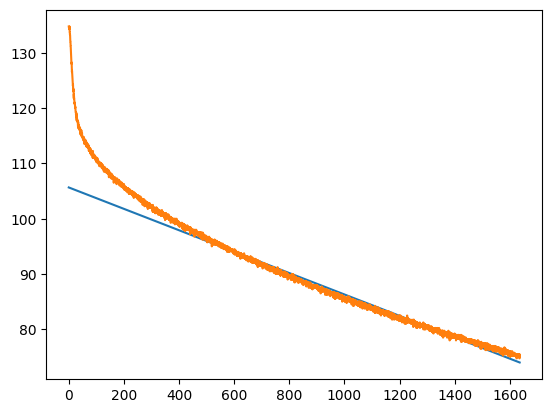

In [7]:
plt.plot(
    sec_fitting,
    (line_shift.value + line_slope.value*(sec_fitting-sec_fitting[1036]))
)
plt.plot(
    sec_fitting,
    temp_fitting
)

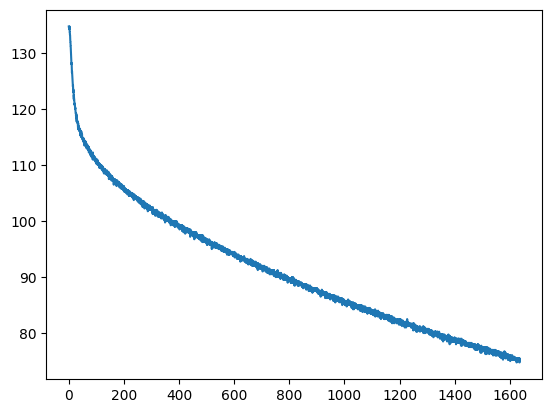

In [8]:
# plt.plot(
#     sec_fitting,
#     3/(sec_fitting/300+0.1) + (line_slope.value + line_shift.value*sec_fitting)
# )
plt.plot(
    sec_fitting,
    temp_fitting
)

# Pressure Profiling

In [275]:
dfs = {
    'pressure': pd.DataFrame(index=np.arange(500), dtype=float),
    'seconds': pd.DataFrame(index=np.arange(500), dtype=float),
    'pump': pd.DataFrame(index=np.arange(500), dtype=float)
}

for filename in os.listdir('../logs/'):
    df_read = pd.read_csv(f'../logs/{filename}', header=None)[0].values
    if len(df_read) > 500:
        continue
    df_read = np.pad(
        df_read, ((0, 500-len(df_read)),), 'constant', constant_values=np.nan
    )

    keys = filename.split('.')[0].split('_')
    datatype = keys[1]
    timestamp = keys[-1]

    if datatype not in dfs.keys():
        continue
    dfs[datatype][timestamp] = df_read

dfs = {
    key: df.set_index([pd.MultiIndex.from_product([[key], df.index])]) 
    for key, df in dfs.items()
}

combined = pd.concat(dfs.values(), axis=0)
null_pressures = [
    colname for colname in combined.columns 
    if np.isnan(combined.loc['pressure', colname].iloc[0])
]
combined.drop(columns=null_pressures, inplace=True)
combined.rename(
    lambda x: int(np.round(6*np.max(combined[x].loc['pump']))), 
    axis=1,
    inplace=True
)

In [276]:
turnon = {}
for i in range(1, 7):
    turnon[i] = np.argmax(combined.loc['pump'][i])

startidx = {}
for i in range(1, 7):
    startidx[i] = np.argmin(combined.loc['pressure'][i].iloc[:turnon[i]+20])

# hit10 = {}
# for i in range(1, 7):
#     pressure_curve = combined.loc['pressure'][i]
#     wherelarge = pressure_curve[pressure_curve > 10]
#     if len(wherelarge) > 0:
#         hit10[i] = np.argmax(pressure_curve > 10)
#     else:
#         hit10[i] = -1

turnoff = {}
for i in range(1, 7):
    turnoff[i] = np.argmin(combined.loc['pump'][i].iloc[turnon[i]:]) + turnon[i]

press_series = []
for i in range(1, 7):
    secs = combined[i].loc['seconds'].iloc[turnon[i]:turnoff[i]].values
    secs -= secs[0]
    press = combined[i].loc['pressure'].iloc[turnon[i]:turnoff[i]].values
    press_series.append(pd.Series(press, index=secs))

In [277]:
term_press = []
for s in press_series:
    s_filtered = lowpass_filter_series(s, 0.05, 5)
    term_press.append(s_filtered.max())

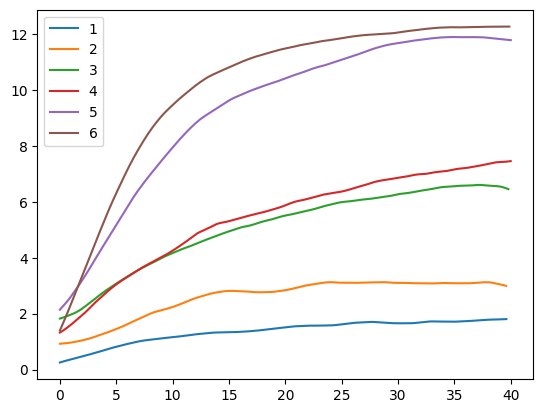

In [278]:
for i in range(1, 7):
    # plt.plot(combined[i].loc['seconds'].iloc[startidx[i]:turnoff[i]],
    # combined[i].loc['pressure'].iloc[startidx[i]:turnoff[i]], label=f'{i}')
    lowpass_filter_series(press_series[i-1], 1/18, 1).plot(label=f'{i}')
plt.legend()
plt.show()

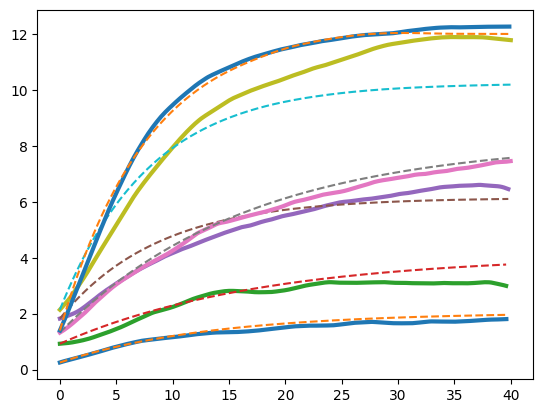

In [263]:
Cs = [0.6, 0.45, 0.92, 0.48, 1., 1.02]
err = 0.

for i in range(1,7):
    s_filtered = lowpass_filter_series(press_series[i-1], 1/18, 1)
    secs = s_filtered.index.values
    press = s_filtered.values

    def h(t):
        return i / 6

    # def system(t, y):
    #     P, F, K = y
    #     dPdt = 0.04 * K * (h(t) * 15 - P)
    #     dFdt = 10.8 - 10.8/15 * P
    #     if F <= 6:
    #         dKdt = 1.3 * F
    #     else:
    #         dKdt = 0. 
    #     return [dPdt, dFdt, dKdt]
    
    # t_span = (0, np.max(secs))

    # # Solve the system of ODEs
    # sol = solve_ivp(
    #     system, t_span, [press[0], 0., 1.], t_eval=secs
    # )

    def system(t, y):
        P = y
        if P >= 12:
            dPdt = 0.1 * (12 - P)
        else:
            dPdt = 0.125 * Cs[i-1] * (h(t) * 12.3 - P)
        return [dPdt]
    
    t_span = (0, np.max(secs))

    # Solve the system of ODEs
    sol = solve_ivp(
        system, t_span, [press[0]], t_eval=secs
    )

    s_filtered.plot(linewidth=3)
    plt.plot(
        secs,
        sol.y[0],
        '--'
    )
    err += np.sum((press - sol.y[0])**2)

plt.show()

# Heat Response Profiling

In [279]:
dfs = {
    'temperature': pd.DataFrame(index=np.arange(4600), dtype=float),
    'seconds': pd.DataFrame(index=np.arange(4600), dtype=float),
    'heat': pd.DataFrame(index=np.arange(4600), dtype=float)
}

for filename in os.listdir('../logs/'):
    df_read = pd.read_csv(f'../logs/{filename}', header=None)[0].values
    if len(df_read) > 4600:
        continue
    df_read = np.pad(
        df_read, ((0, 4600-len(df_read)),), 'constant', constant_values=np.nan
    )

    keys = filename.split('.')[0].split('_')
    datatype = keys[1]
    timestamp = keys[-1]

    if datatype not in dfs.keys():
        continue
    dfs[datatype][timestamp] = df_read

dfs = {
    key: df.set_index([pd.MultiIndex.from_product([[key], df.index])]) 
    for key, df in dfs.items()
}

combined = pd.concat(dfs.values(), axis=0)
null_heats = [
    colname for colname in combined.columns 
    if np.isnan(combined.loc['heat', colname].iloc[0])
]
combined.drop(columns=null_heats, inplace=True)
null_heats = [
    colname for colname in combined.columns 
    if int(np.round(6*np.max(combined[colname].loc['heat']))) == 6 
    and (combined[colname].loc['seconds'] > 0).sum() < 600
]
combined.drop(columns=null_heats, inplace=True)
combined.rename(
    lambda x: int(np.round(6*np.max(combined[x].loc['heat']))), 
    axis=1,
    inplace=True
)

In [280]:
indices = [2, 4, 5, 6]

turnon = {}
for i in indices:
    turnon[i] = np.argmax(combined.loc['heat'][i])

startidx = {}
for i in indices:
    startidx[i] = np.argmin(combined.loc['temperature'][i].iloc[:turnon[i]+10])

# hit10 = {}
# for i in indices:
#     temp_curve = combined.loc['temperature'][i]
#     wherelarge = temp_curve[temp_curve > 10]
#     if len(wherelarge) > 0:
#         hit10[i] = np.argmax(temp_curve > 10)
#     else:
#         hit10[i] = -1

turnoff = {}
for i in indices:
    turnoff[i] = np.argmin(combined.loc['heat'][i].iloc[turnon[i]:]) + turnon[i]

endidx = {}
for i in indices:
    endidx[i] = np.argmax(np.isnan(combined.loc['heat'][i]))

temps_series = {}
for i in indices:
    secs = combined.loc['seconds'][i].iloc[turnon[i]:endidx[i]].values
    secs -= secs[0]
    temps = combined.loc['temperature'][i].iloc[turnon[i]:endidx[i]].values
    temps_series[i] = pd.Series(temps, index=secs)

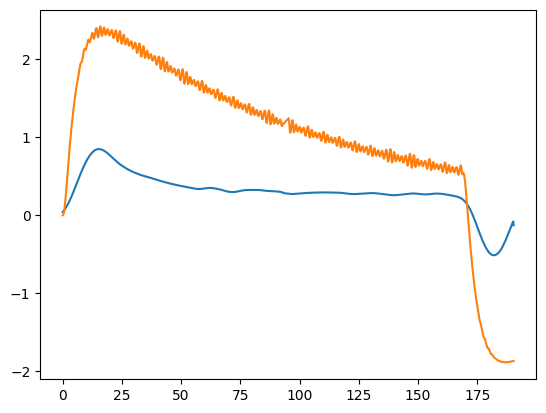

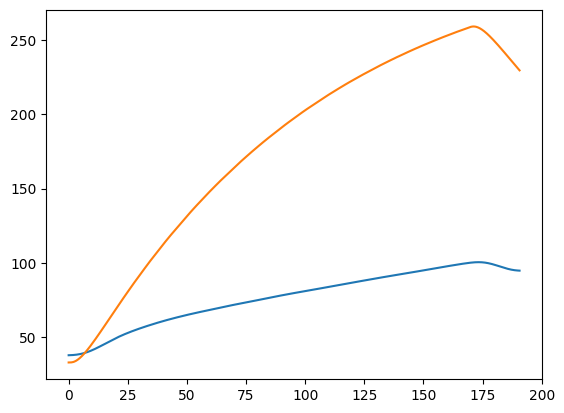

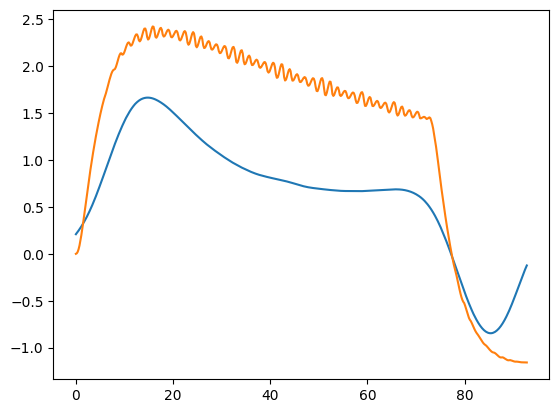

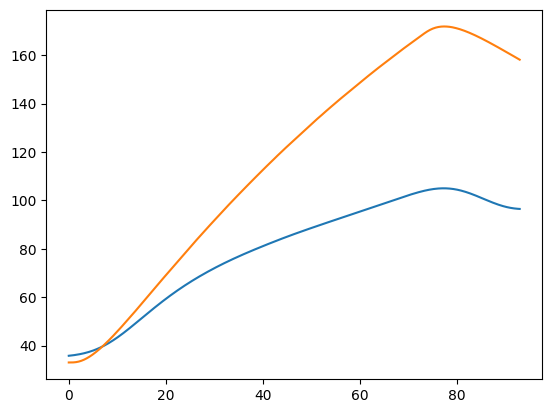

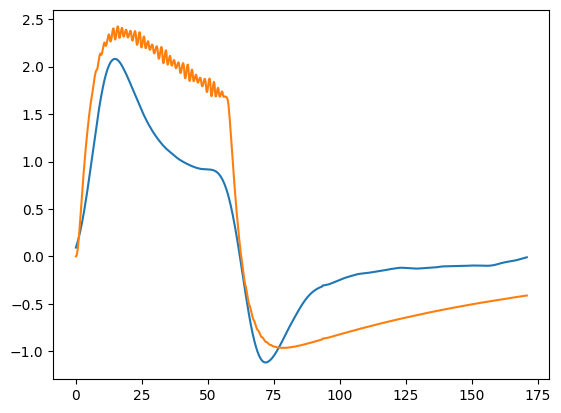

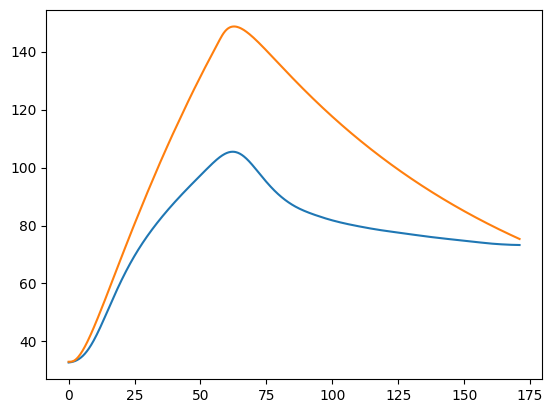

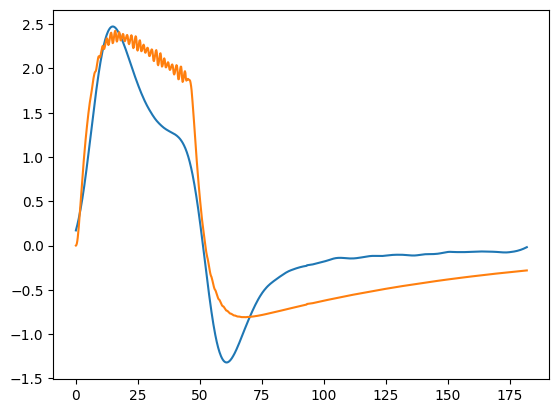

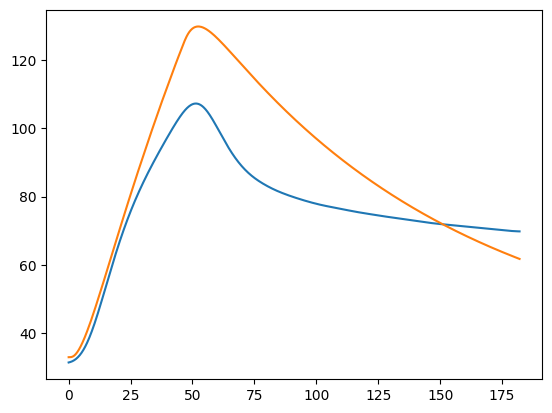

In [281]:
for i in [2, 4, 5, 6]:
    s_filtered = lowpass_filter_series(temps_series[i], 0.05, 2)
    secs = s_filtered.index.values
    temps = s_filtered.values

    def h(t):
        if t <= secs[turnoff[i] - turnon[i]]:
            return 1.
        else:
            return 0.

    def system(t, y):
        T, C, R, H = y # pressure, temperature, effective heat
        dTdt = (300. * (C - T)) / (60 * 4.187)
        dCdt = (1700 * R + 250. * (T - C) + 6. * (33 - C)) / (450 * 0.9)
        dRdt = 2. * (H - R)
        dHdt = 0.2 * (h(t) - H)
        return [dTdt, dCdt, dRdt, dHdt]
    
    t_span = (0, np.max(secs))

    # Solve the system of ODEs
    sol = solve_ivp(
        system, t_span, [33., 33., 0., 0.], t_eval=secs
    )

    # plt.plot(
    #     secs,
    #     temps,
    #     label=str(i)
    # )
    plt.plot(
        secs[:-1],
        np.ediff1d(temps) / np.ediff1d(secs)
    )

    plt.plot(
        secs[:-1],
        np.ediff1d(sol.y[0]) / np.ediff1d(secs)
    )
    plt.show()
    plt.plot(
        secs,
        temps
    )
    plt.plot(
        secs,
        sol.y[0]
    )
    plt.show()

In [283]:
z_transform_series(
    lowpass_filter_series(
        temps_series[2].iloc[:turnoff[i]-turnon[i]], 
        0.05, 
        2
    )
)

TypeError: z_transform_series() missing 2 required positional arguments: 'a' and 'b'

In [ ]:
array([1.11414447e+02, 4.61278606e+03, 2.82421593e+01, 5.70742386e+02,
       1.85745237e+00, 2.16687250e-02])

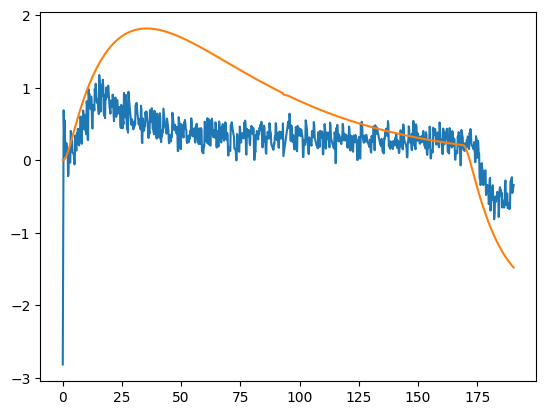

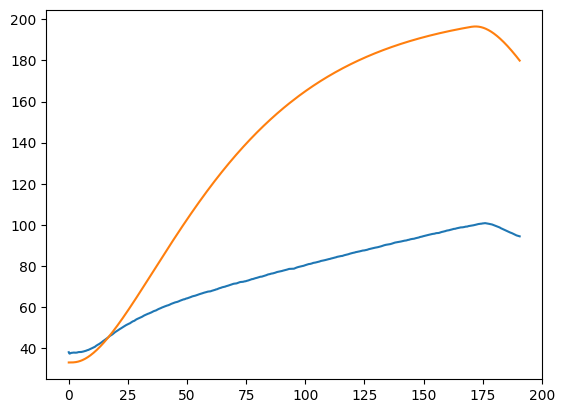

In [367]:
for i in [2]:
    secs = combined.loc['seconds'][i].iloc[turnon[i]:endidx[i]].values
    secs -= secs[0]
    temps = combined.loc['temperature'][i].iloc[turnon[i]:endidx[i]].ewm(10).mean().values

    def h(t):
        if t <= secs[turnoff[i] - turnon[i]]:
            return 1.
        else:
            return 0.

    def system(t, y):
        T, C, A, R, H = y # pressure, temperature, effective heat
        dTdt = (111. * (C - T)) / (60 * 4.187)
        dCdt = (4612 * R + 111. * (T - C) + 28. * (A - C)) / (450 * 0.9)
        dAdt = (28. * (C - A) + 570. * (33 - A)) / (5.7)
        dRdt = 1.8 * (H - R)
        dHdt = 0.022 * (h(t) - H)
        return [dTdt, dCdt, dAdt, dRdt, dHdt]
    
    t_span = (0, np.max(secs))

    # Solve the system of ODEs
    sol = solve_ivp(
        system, t_span, [33., 33., 33., 0., 0.], t_eval=secs
    )

    # plt.plot(
    #     secs,
    #     temps,
    #     label=str(i)
    # )
    plt.plot(
        secs[:-1],
        np.ediff1d(temps) / np.ediff1d(secs)
    )

    plt.plot(
        secs[:-1],
        np.ediff1d(sol.y[0]) / np.ediff1d(secs)
    )
    plt.show()
    plt.plot(
        secs,
        temps
    )

    plt.plot(
        secs,
        sol.y[0]
    )
    plt.show()

# idx = 6
# secs = combined.loc['seconds'][idx].iloc[turnon[idx]:turnoff[idx]].values
# secs -= secs[0]

# term_temp = 150
# delay = 5.2
# scale = 42

# plt.plot(
#     secs,
#     np.maximum(31, -(term_temp - 31) * np.exp(-(secs - delay)/scale) + term_temp)
# )
# plt.legend()
# plt.show()

In [241]:
temps[0]

103.0

$\dot T_b = \frac{570}{450\times 0.89}u$

In [ ]:
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

In [359]:
def u(t):
    return 0.0

def obj(HC):

    err = 0.
    
    for idx in [2, 4, 5, 6]:
        secs = combined.loc['seconds'][idx].iloc[turnon[idx]:endidx[idx]].values
        secs -= secs[0]
        temps = combined.loc['temperature'][idx].iloc[turnon[idx]:endidx[idx]].values
        init_temp = temps[0]
        # init_cond = [0., init_temp, init_temp, init_temp]

        def h(t):
            if t <= secs[turnoff[idx] - turnon[idx]]:
                return idx / 6
            else:
                return 0.

        # def system(t, y):
        #     T, H = y # pressure, temperature, effective heat
        #     dTdt = HC[0] * H + HC[1] * (init_temp - T) 
        #     dHdt = HC[2] * (h(t) - H)
        #     # dAdt = HC[0] * 140 * (B - A) / (5.74 * 1.012)
        #     # dTdt = HC[1] * 4 * 3.137 * 10.16 * (B - T) / (100 * 4.186)
        #     # dBdt = (570. * H  + HC[1] * 4 * 3.137 * 10.16 * (T - B) + HC[0] * 140 * (A - B)) / (450 * 0.89)
        #     # dHdt = HC[2] * (h(t) - H)
        #     return [dTdt, dHdt]
        
        # sol = solve_ivp(
        #     system, (0, secs[-1]), init_cond, t_eval=secs
        # )

    #     secs = combined.loc['seconds'][i].iloc[turnon[i]:endidx[i]].values
    # secs -= secs[0]
    # temps = combined.loc['temperature'][i].iloc[turnon[i]:endidx[i]].ewm(10).mean().values

        def system(t, y):
            T, C, A, R, H = y # pressure, temperature, effective heat
            dTdt = (HC[0] * (C - T)) / (60 * 4.187)
            dCdt = (HC[1] * R + HC[0] * (T - C) + HC[2] * (A - C)) / (450 * 0.9)
            dAdt = (HC[2] * (C - A) + HC[3] * (33 - A)) / (5.7)
            dRdt = HC[4] * (H - R)
            dHdt = HC[5] * (h(t) - H)
            return [dTdt, dCdt, dAdt, dRdt, dHdt]
        
        t_span = (0, np.max(secs))

        # Solve the system of ODEs
        sol = solve_ivp(
            system, t_span, [init_temp, init_temp, init_temp, 0., 0.], t_eval=secs
        )
        
        err += np.sum((sol.y[0] - temps)**2)

    return err
    # return sol.y[1]

In [361]:
results = minimize(
    obj, np.array([210., 4300., 60., 1200., 0.2, 0.1]),
    bounds=[(0, 1000), (570, 10000), (0, 300), (10, 5000), (0, 2), (0, 2)],
    options={'maxiter': 20}
)

In [362]:
results.x

array([1.11414447e+02, 4.61278606e+03, 2.82421593e+01, 5.70742386e+02,
       1.85745237e+00, 2.16687250e-02])

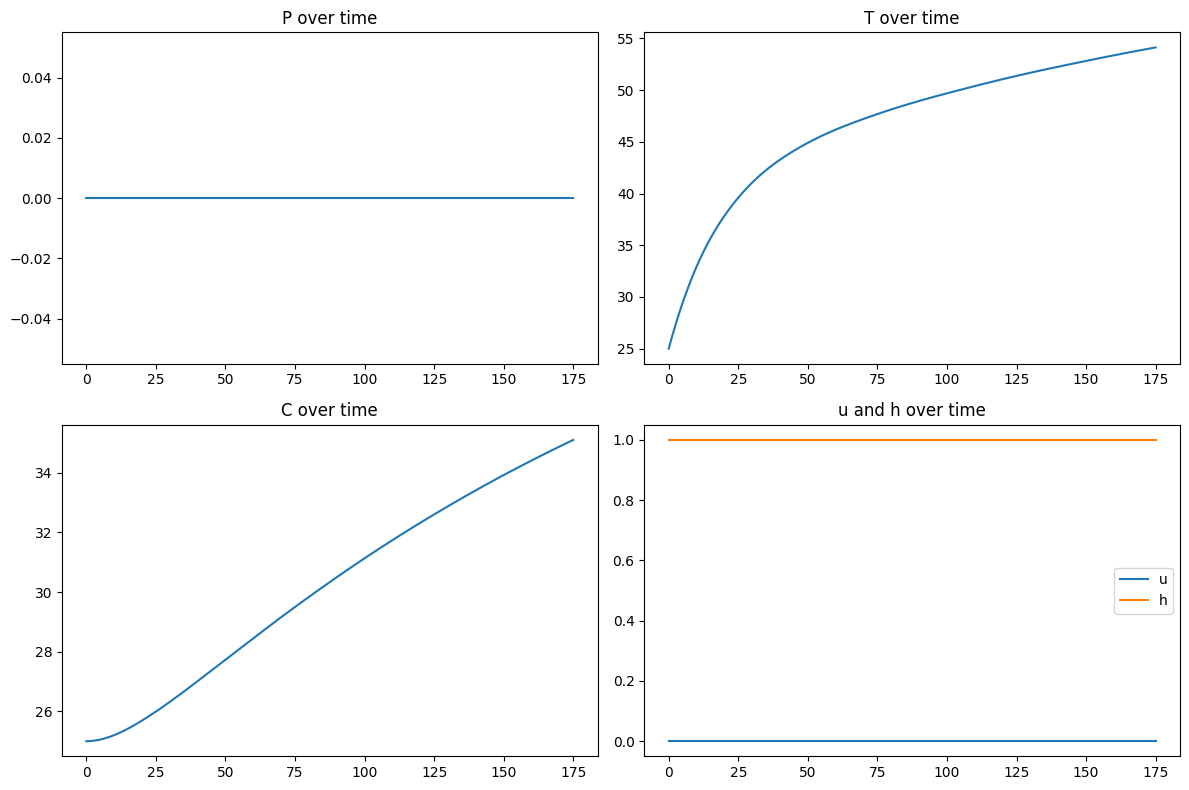

In [160]:
# Constants
C1 = -1.  # replace with your actual value
C2 = 1.  # replace with your actual value
C3 = 0.  # replace with your actual value
C4 = 1/20.  # replace with your actual value
C5 = 0.  # replace with your actual value
C6 = 1.  # replace with your actual value
C7 = 0.  # replace with your actual value
C8 = 1/200.  # replace with your actual value
C9 = 1/200.  # replace with your actual value

# Control inputs (functions of time)
def u(t):
    # replace with your actual function of time
    return 0.

def h(t):
    # replace with your actual function of time
    return 1.

# System of ODEs
def system(t, y):
    P, T, C = y
    dPdt = C1*P + C2*u(t) + C3
    dTdt = C4*(C - T) + C5*P + C6*h(t) + C7
    dCdt = C8*(T - C) + C9*(25 - C)
    return [dPdt, dTdt, dCdt]

# Initial conditions
P0 = 0.  # replace with your actual initial condition
T0 = 25.  # replace with your actual initial condition
C0 = 25.  # replace with your actual initial condition

# Time span
t_span = (0, 175)  # replace with your actual time span

# Solve the system of ODEs
sol = solve_ivp(system, t_span, [P0, T0, C0], t_eval=np.linspace(*t_span, 500))

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(sol.t, sol.y[0])
plt.title('P over time')

plt.subplot(2, 2, 2)
plt.plot(sol.t, sol.y[1])
plt.title('T over time')

plt.subplot(2, 2, 3)
plt.plot(sol.t, sol.y[2])
plt.title('C over time')

plt.subplot(2, 2, 4)
plt.plot(sol.t, [u(t) for t in sol.t], label='u')
plt.plot(sol.t, [h(t) for t in sol.t], label='h')
plt.legend()
plt.title('u and h over time')

plt.tight_layout()
plt.show()


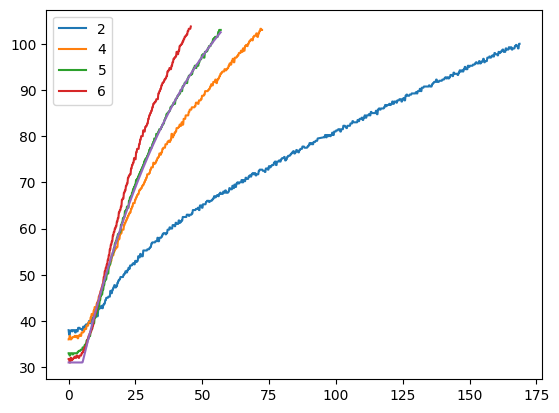

In [69]:
for i in indices:
    secs = combined.loc['seconds'][i].iloc[turnon[i]:turnoff[i]].values
    secs -= secs[0]
    plt.plot(
        secs,
        combined.loc['temperature'][i].iloc[turnon[i]:turnoff[i]].values,
        label=str(i)
    )
idx = 5
secs = combined.loc['seconds'][idx].iloc[turnon[idx]:turnoff[idx]].values
secs -= secs[0]

term_temp = 132
delay = 5.2
scale = 42

plt.plot(
    secs,
    np.maximum(31, -(term_temp - 31) * np.exp(-(secs - delay)/scale) + term_temp)
)
plt.legend()
plt.show()

Error: 1005.2429155735352


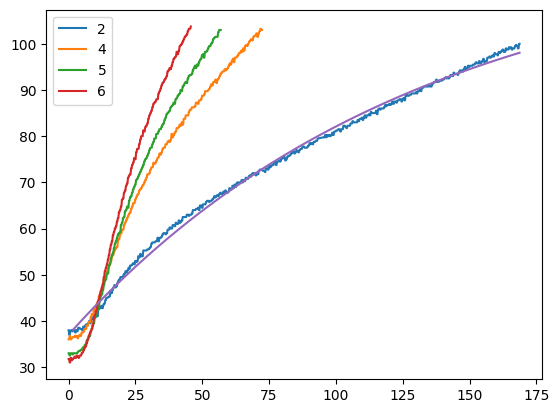

In [141]:
for i in indices:
    secs = combined.loc['seconds'][i].iloc[turnon[i]:turnoff[i]].values
    secs -= secs[0]
    plt.plot(
        secs,
        combined.loc['temperature'][i].iloc[turnon[i]:turnoff[i]].values,
        label=str(i)
    )

idx = 2
min_val = np.inf
min_delay = 0.
min_scale = 10.
min_term = 0.

for delay in np.linspace(0., 3., 25):
    for scale in np.linspace(120., 200., 25):
        secs = combined.loc['seconds'][idx].iloc[turnon[idx]:turnoff[idx]].values
        secs -= secs[0]
        temps = combined.loc['temperature'][idx].iloc[turnon[idx]:turnoff[idx]].values

        start_temp = temps[0]
        first_idx = np.argmax(secs >= delay)
        secs = secs[first_idx:]
        temps = temps[first_idx:]

        curve = np.exp(-(secs - delay) / scale)
        X = np.vstack((np.ones_like(curve), curve)).T

        term_temp = cp.Variable()
        stacked = cp.hstack([term_temp, start_temp - term_temp])

        prob = cp.Problem(
            cp.Minimize(
                cp.sum_squares(X @ stacked - temps)
            ), []
        )
        val = prob.solve()
        if val < min_val:
            min_val = val
            min_delay = delay
            min_scale = scale
            min_term = term_temp.value
print(f"Error: {min_val}")

secs = combined.loc['seconds'][idx].iloc[turnon[idx]:turnoff[idx]].values
secs -= secs[0]
temps = combined.loc['temperature'][idx].iloc[turnon[idx]:turnoff[idx]].values

start_temp = temps[0]
first_idx = np.argmax(secs >= min_delay)
secs = secs[first_idx:]
temps = temps[first_idx:]

plt.plot(
    secs,
    np.maximum(start_temp, -(min_term - start_temp) * np.exp(-(secs - min_delay)/min_scale) + min_term)
)
plt.legend()
plt.show()

In [145]:
min_delay

1.5

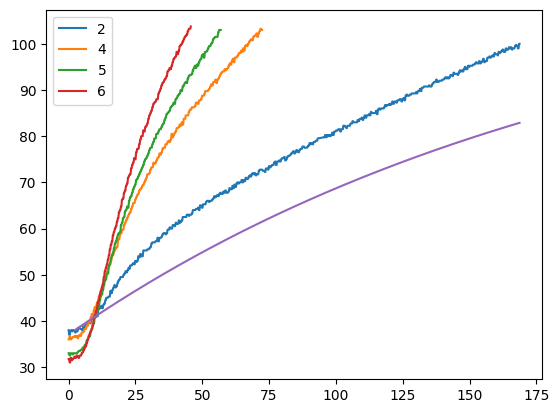

In [140]:
for i in indices:
    secs = combined.loc['seconds'][i].iloc[turnon[i]:turnoff[i]].values
    secs -= secs[0]
    plt.plot(
        secs,
        combined.loc['temperature'][i].iloc[turnon[i]:turnoff[i]].values,
        label=str(i)
    )

secs = combined.loc['seconds'][idx].iloc[turnon[idx]:turnoff[idx]].values
secs -= secs[0]
temps = combined.loc['temperature'][idx].iloc[turnon[idx]:turnoff[idx]].values

start_temp = temps[0]
first_idx = np.argmax(secs >= min_delay)
secs = secs[first_idx:]
temps = temps[first_idx:]

plt.plot(
    secs,
    np.maximum(start_temp, -(min_term - start_temp) * np.exp(-(secs - min_delay)/200) + min_term)
)
plt.legend()
plt.show()

In [57]:
idx = 6

In [67]:
temp_fitting = combined.loc['temperature'][idx].iloc[turnon[idx]:turnoff[idx]].values
secs_fitting = combined.loc['seconds'][idx].iloc[turnon[idx]:turnoff[idx]].values
secs_fitting -= secs_fitting[0]
offset = np.ones_like(secs_fitting)
X = np.vstack([offset] + [np.sqrt(secs_fitting + j) for j in range(20)]).T

In [71]:
beta = cp.Variable(X.shape[1])

obj = cp.Minimize(cp.sum_squares(X @ beta - temp_fitting) + cp.norm1(beta))
prob = cp.Problem(obj, [beta >= 0])
prob.solve()

4846.877300976805

In [72]:
beta.value

array([-3.59156563e-04,  7.74632632e-05,  1.35317273e+01,  1.23171098e+00,
       -5.93330062e-05, -9.11783278e-05, -1.19524733e-04, -1.45049577e-04,
       -1.68224355e-04, -1.89399259e-04, -2.08843893e-04, -2.26772730e-04,
       -2.43361023e-04, -2.58753183e-04, -2.73071777e-04, -2.86420900e-04,
       -2.98889638e-04, -3.10556820e-04, -3.21490643e-04, -3.31750571e-04,
       -3.41390282e-04])

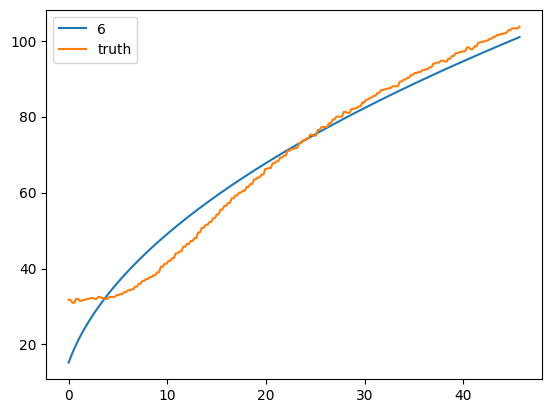

In [73]:
plt.plot(
    secs_fitting,
    X @ beta.value,
    # combined.loc['seconds'][i].iloc[turnon[i]:turnoff[i]],
    # combined.loc['temperature'][i].iloc[turnon[i]:turnoff[i]],
    label=str(idx)
)
plt.plot(
    secs_fitting,
    temp_fitting,
    # combined.loc['seconds'][i].iloc[turnon[i]:turnoff[i]],
    # combined.loc['temperature'][i].iloc[turnon[i]:turnoff[i]],
    label='truth'
)
plt.legend()
plt.show()

# Archive

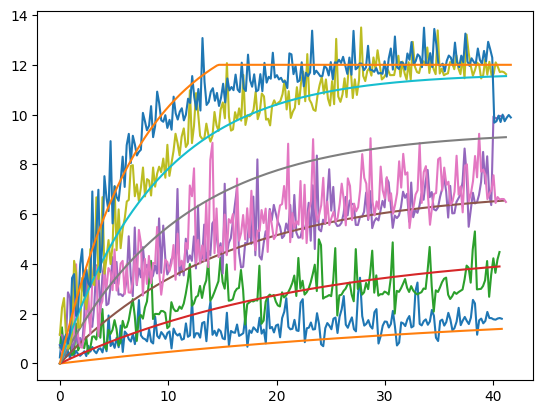

In [187]:
for idx in range(1, 7):
    press_plotting = combined.loc['pressure'][idx].iloc[turnon[idx]:].values
    secs_plotting = combined.loc['seconds'][idx].iloc[turnon[idx]:].values
    secs_plotting -= secs_plotting[0]
    offset = np.ones_like(secs_plotting)
    X_plotting = np.vstack((offset, secs_plotting)).T

    plt.plot(secs_plotting, press_plotting)
    plt.plot(
        secs_plotting, np.minimum(12,14*(1 - np.exp(-secs_plotting/45*idx))*idx/6)
    )
plt.show()

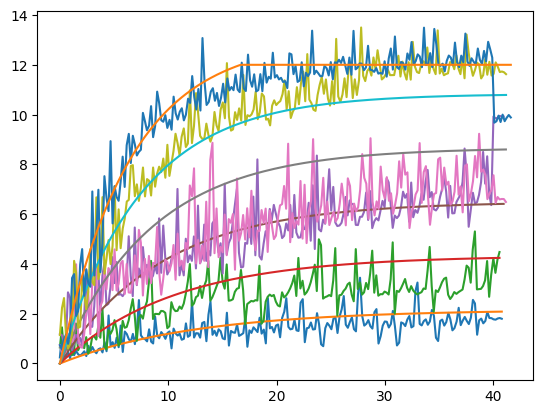

In [239]:
coeffs = [12.5, 10.5, 9.5, 8.5, 7.5, 6.5]
for idx in range(1, 7):
    press_plotting = combined.loc['pressure'][idx].iloc[turnon[idx]:].values
    secs_plotting = combined.loc['seconds'][idx].iloc[turnon[idx]:].values
    secs_plotting -= secs_plotting[0]
    offset = np.ones_like(secs_plotting)
    X_plotting = np.vstack((offset, secs_plotting)).T

    plt.plot(secs_plotting, press_plotting)
    plt.plot(
        secs_plotting, np.minimum(12,13*(1 - np.exp(-secs_plotting/coeffs[idx-1]))*idx/6)
    )
plt.show()

In [154]:
press_plotting = combined.loc['pressure'][idx].iloc[turnon[idx]:].values
secs_plotting = combined.loc['seconds'][idx].iloc[turnon[idx]:].values
secs_plotting -= secs_plotting[0]
offset = np.ones_like(secs_plotting)
X_plotting = np.vstack((offset, secs_plotting)).T

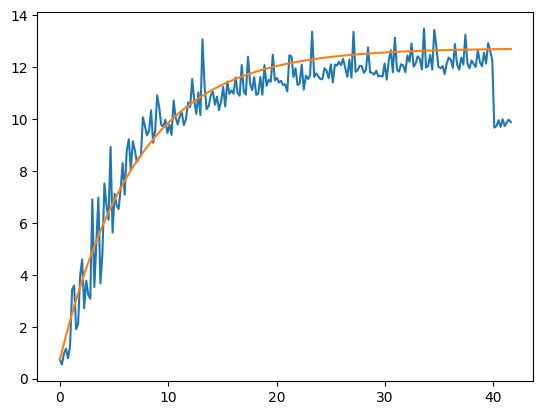

In [160]:
plt.plot(secs_plotting, press_plotting)
plt.plot(
    secs_plotting, press_plotting[0]+12*(1 - np.exp(-secs_plotting/7*1/(7-idx)))*idx/6
)
plt.show()

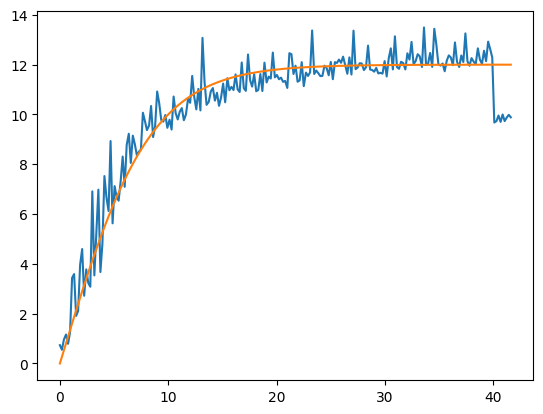

In [27]:
plt.plot(secs_plotting, press_plotting)
plt.plot(secs_plotting, 24 / (1 + np.exp(-X_plotting @ np.array([0, 6/25.]))) - 12)
plt.show()

In [28]:
times = np.fromiter(
    map(lambda x: pd.Timestamp(x).to_datetime64(), 
        combined[idx].loc['seconds'].iloc[startidx[idx]:turnoff[idx]] * 1e9),
    dtype=np.dtype('datetime64[ns]')
)

In [29]:
combined[idx].loc['pressure'].iloc[startidx[idx]:turnoff[idx]].ewm(
    halflife=np.timedelta64(int(1e9)),
    ignore_na=True,
    times=times[:212]
).mean()
pass

In [ ]:
i = 6
press_fitting = combined.loc['pressure'][i].iloc[turnon[i]:hit10[i]].values
secs_fitting = combined.loc['seconds'][i].iloc[turnon[i]:hit10[i]].values
secs_fitting -= secs_fitting[0]
offset = np.ones_like(secs_fitting)
X = np.vstack((offset, secs_fitting)).T

coeffs = cp.Variable(2)

logit = X @ coeffs
constraints = [
    24 * cp.inv_pos(1 + cp.exp(logit[j])) - 12 - press_fitting[j] >= -0.01
    for j in range(len(press_fitting))
]
constraints += [
    24 * cp.inv_pos(1 + cp.exp(logit[j])) - 12 - press_fitting[j] <= 0.01
    for j in range(len(press_fitting))
]

prob = cp.Problem(
    cp.Minimize(cp.sum(coeffs)), 
    constraints
)
prob.solve(qcp=True, solver='SCS')

In [284]:
import lcapy

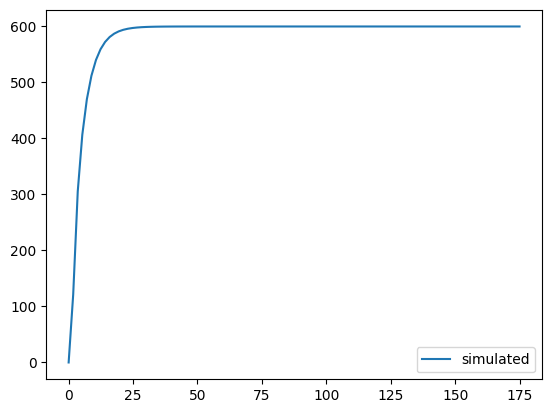

In [340]:
cct = lcapy.Circuit("""
V 1 0 step 600; down
R1 1 2 0.004; right
C1 2 3 405; right
R2 3 4 0.005; right
C2 4 5 4; right
R3 5 6 0.0005; right, ground
R4 3 7 0.004; down
W 7 0_2; left
W 0_2 0; up
R5 3 8 0.01; up
C3 8 9 100; left
R6 9 2 0.01; down
; label_ids=false, label_nodes=none
""")
                    
tv = np.linspace(0, 175, 100)

results = cct.sim(tv)

# ax = cct.R1.v.plot(tv, label='analytic')
plt.plot(tv, results.C1.v, label='simulated')
plt.legend()
plt.show()


/home/lmbell/VSCode-Projects/Convespresso/convespresso/.venv/lib/python3.10/site-packages/lcapy/simulator.py:363: UserWarning: Initial conditions for C1 ignored
  warn('Initial conditions for %s ignored' % elt.name)
/home/lmbell/VSCode-Projects/Convespresso/convespresso/.venv/lib/python3.10/site-packages/lcapy/simulator.py:363: UserWarning: Initial conditions for C2 ignored
  warn('Initial conditions for %s ignored' % elt.name)
/home/lmbell/VSCode-Projects/Convespresso/convespresso/.venv/lib/python3.10/site-packages/lcapy/simulator.py:363: UserWarning: Initial conditions for C3 ignored
  warn('Initial conditions for %s ignored' % elt.name)


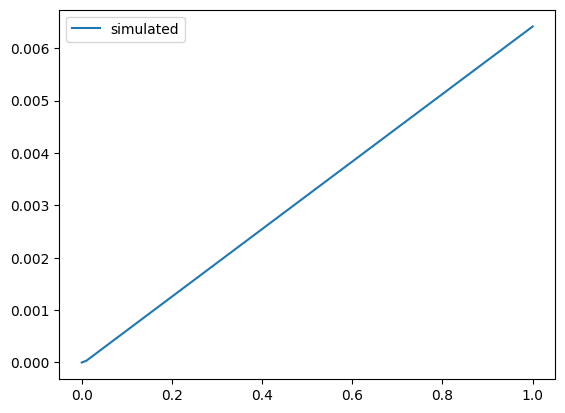

In [330]:
tv = np.linspace(0, 1, 100)

results = cct.sim(tv)

# ax = cct.R1.v.plot(tv, label='analytic')
plt.plot(tv, results.C1.v, label='simulated')
plt.legend()
plt.show()

In [331]:
a

array([ 1.        , -4.8082678 ,  9.25132335, -8.90329855,  4.28573621,
       -0.82549254])